**루브릭 1. 자기만의 카메라앱 기능 구현을 완수하였다.**  
얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였다.

-> 랜드마크 검출과 스티커 사진 합성을 완료했습니다.

**루브릭 2. 스티커 이미지를 정확한 원본 위치에 반영하였다.**  
정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.

-> 고양이 수염의 위치가 적절하게 출력되었습니다.

**루브릭 3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.**  
얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.

-> 분석해보았습니다.

**참고사항**

(1) 이번 exploration은 10월 14일에서 15일로 넘어가는 자정까지가 기한입니다.
하지만, 조금 미비한 부분들이 있어서, 깃허브 주소는 자정 전에 게시하겠지만, 그 후에 약간의 수정이 있을 것 같습니다.
혹시 채점하시는 퍼실님이 이 글을 보신다면, 3-4시간 정도만 더 있다가 이 exploration을 채점해주셨으면 합니다.
제출과제가 조금 늦어지는 점 죄송합니다.

# 1. 스티커 붙이기

## 1.1. 사전작업

### 1.1.1. 모듈 불러오기

cell 1

In [1]:
import os, cv2, dlib
import matplotlib.pyplot as plt
import numpy as np

### 1.1.2. 사진 파일 불러오기

cell 2

<Before preprocessing>


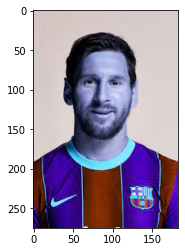

<After preprocessing>


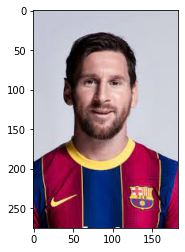

In [2]:
#이미지 경로설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/messi.jfif'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr_orig = img_bgr.copy() # 투명도 작업용 변수

img_show = img_bgr.copy() #출력용 이미지는 따로 보관함.

print("<Before preprocessing>")
plt.imshow(img_bgr)
plt.show()

##이미지 색상 보정처리
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_bgr_rot = img_rgb.copy() # 회전 작업용 변수
img_dark = img_rgb.copy() # 어두운 사진 작업용 변수
img_far = img_rgb.copy() # 얼굴 작게 나온 사진 작업용 변수

print("<After preprocessing>")
plt.imshow(img_rgb)
plt.show()

### 1.1.3. 전처리 작업

## 1.2. 바운딩 박스 생성

cell 3

<Face detection rsult>


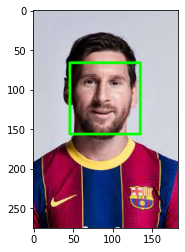

In [3]:
# HOG 얼굴 바운딩박스 탐지기 생성 및 할당
detector_hog = dlib.get_frontal_face_detector()

#얼굴 바운딩박스 추출 - 얼굴 검출기를 이미지에 적용
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

# 이미지 피라미드? - 이미지를 upsampling해서 크기를 키우는 것
# 작게 촬영된 얼굴을 크게 보게 만드는것 - 정확한 검출 가능

# 찾은 얼굴 영역 좌표 
for dlib_rect in dlib_rects: 
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
print("<Face detection rsult>")
plt.imshow(img_show_rgb)
plt.show()

## 1.2. 랜드마크 생성

cell 4

In [4]:
#얼굴 랜드마크 예측 모델 불러오기
#지정한 모델 불러오기
#landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

cell 5

68
[[(50, 93), (50, 104), (50, 114), (51, 125), (54, 135), (60, 144), (67, 152), (76, 158), (85, 160), (94, 159), (103, 153), (110, 146), (117, 137), (121, 127), (123, 116), (124, 106), (124, 95), (58, 86), (62, 81), (69, 79), (76, 80), (83, 82), (96, 83), (102, 81), (108, 81), (114, 84), (118, 89), (88, 90), (87, 97), (87, 104), (86, 111), (79, 115), (82, 117), (86, 119), (91, 117), (95, 116), (66, 91), (70, 89), (75, 89), (79, 92), (74, 93), (70, 93), (97, 93), (101, 91), (106, 91), (109, 93), (106, 94), (101, 94), (73, 127), (78, 126), (83, 126), (87, 127), (92, 126), (97, 127), (102, 128), (96, 134), (91, 136), (86, 136), (82, 136), (77, 133), (75, 128), (83, 129), (87, 129), (92, 129), (99, 128), (91, 132), (87, 132), (82, 131)]]


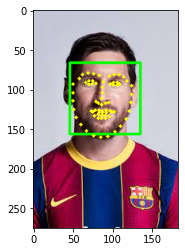

In [5]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
print(list_landmarks)

# 찾은 랜드마크 영상에 출력하기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 1.3. 스티커 붙이기

cell 6

In [6]:
#코위치확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 데이터 셋 인덱스에서 코끝의 index는 33 입니다
    x = landmark[33][0]
    y = landmark[33][1] #- dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y)) #바운딩 박스 내 코끝 랜드마크의 좌표
    print ('(w,h) : (%d,%d)'%(w,h)) #바운딩 박스 크기

(86, 119)
(x,y) : (86,119)
(w,h) : (90,90)


cell 7

In [7]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(90, 90, 3)


cell 8

In [8]:
refined_x = x // 2 #정 중앙에 위치
refined_y = y // 2  # 정 중앙에 위치
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (43,59)


cell 9

In [9]:
#음수값 만큼 crop해주기
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

#이미지 정 중앙에 삽입하므로 -값 발생 x

(x,y) : (43,59)


cell 10

In [10]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
# 원본이미지img_show의 [] 내부에 해당하는 부분은 새로운 값을 재위치키라는 뜻

cell 11

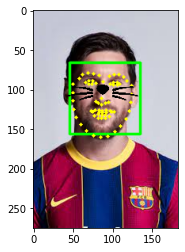

In [11]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

plt.show() #스티커 위치가 제대로 들어갔는지 확인

cell 12

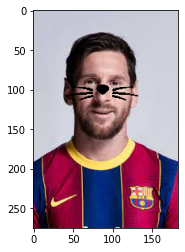

In [12]:
#바운딩 박스 및 랜드마크 제거
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

cell 13

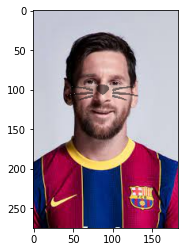

In [13]:
sticker_area = img_bgr_orig[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 2. 다양한 실험들

## 2.1. 사진 회전

cell 14

(91.5, 137.5)
<Face detection bounding box>


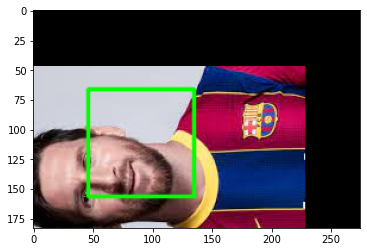

<Landmark result : Fail>


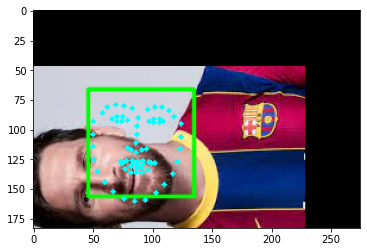

<Attatch sticker : Fail>


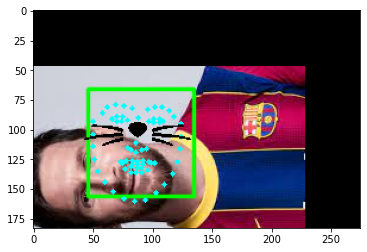

In [14]:
#새 이미지 기져오기 - 이미 RGB 변환 되어있는 이미지 
plt.imshow(img_bgr_rot)
plt.show

#이미지 회전시키기
width, height = img_bgr_rot.shape[:2] #(1080, 1080)
cp = (img_bgr_rot.shape[1] / 2, img_bgr_rot.shape[0] / 2) #회전 중심축 좌표 설정
print(cp)

img_rot = cv2.getRotationMatrix2D(cp, 90, 1) 
img_rot_dst = cv2.warpAffine(img_bgr_rot,img_rot,(width,height))


# plt.imshow(img_rot_dst)
# plt.show


#회전 이미지의 bounding box 확인
for dlib_rect in dlib_rects: 
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_rot_dst, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

print("<Face detection bounding box>")
plt.imshow(img_rot_dst)
plt.show()

#회전 이미지의 랜드마크 확인

list_landmarks_rot = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks_rot.append(list_points)

# print(len(list_landmarks_rot[0]))
# print(list_landmarks_rot)

# 찾은 랜드마크 영상에 출력하기
for landmark in list_landmarks_rot:
    for point in landmark:
        cv2.circle(img_rot_dst, point, 2, (0, 255, 255), -1)
print("<Landmark result : Fail>")
plt.imshow(img_rot_dst)
plt.show()


#회전된 이미지에 스티커 삽입

sticker_area = img_rot_dst[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_rot_dst[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
(print("<Attatch sticker : Fail>"))
plt.imshow(img_rot_dst)
plt.show()

## 2.2. 어두운/밝은 사진

cell 15

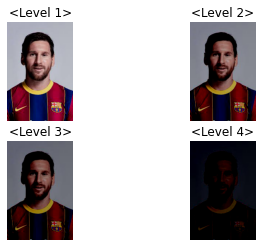

In [15]:
#어두운 사진불러오기
img_drk_1 = np.ones(img_dark.shape, dtype = "uint8") * 25
img_drk_2 = np.ones(img_dark.shape, dtype = "uint8") * 75
img_drk_3 = np.ones(img_dark.shape, dtype = "uint8") * 100
img_drk_4 = np.ones(img_dark.shape, dtype = "uint8") * 200

sub_1 = cv2.subtract(img_dark,img_drk_1)
sub_2 = cv2.subtract(img_dark,img_drk_2)
sub_3 = cv2.subtract(img_dark,img_drk_3)
sub_4 = cv2.subtract(img_dark,img_drk_4)

sub = [sub_1,sub_2,sub_3,sub_4]
sub_output = [sub_1,sub_2,sub_3,sub_4]

# plt.imshow(sub_1)
# plt.show()

for i in range(1,5):
    sub_image = sub[i-1]
    plt.subplot(2,2,i)
    plt.axis("off")
    plt.title(f"<Level {i}>")
    plt.imshow(sub_image)
    
# plt.subplot(1,4,1) #sublplot 모양 1x4 형태로 나열
# plt.axis('off') # 축없애기
# plt.imshow(sub_1) #이미지 산출

cell 16

<Face detection bounding box>
<Face detection bounding box>
<Face detection bounding box>
<Face detection bounding box>


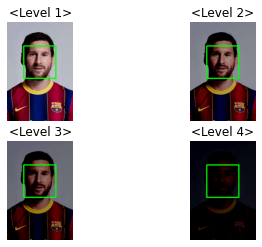

In [16]:
#회전 이미지의 bounding box 확인
for i in range(4):
    for dlib_rect in dlib_rects: 
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(sub[i], (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    print("<Face detection bounding box>")
    plt.subplot(2,2,i+1)
    plt.axis("off")
    plt.title(f"<Level {i+1}>")
    plt.imshow(sub[i])

cell 17

<Landmark result Level 1>


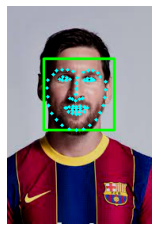

<Landmark result Level 2>


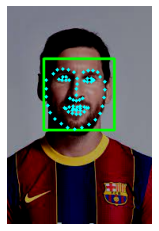

<Landmark result Level 3>


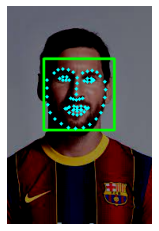

<Landmark result Level 4>


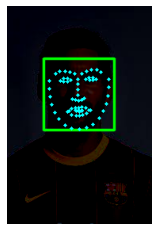

In [17]:
#회전 이미지의 랜드마크 확인
for i in range(4):
    list_landmarks_rot = []

    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    for dlib_rect in dlib_rects:
        points = landmark_predictor(sub[i], dlib_rect)
        # face landmark 좌표를 저장해둡니다
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks_rot.append(list_points)

    # 찾은 랜드마크 영상에 출력하기
    for landmark in list_landmarks_rot:
        for point in landmark:
            cv2.circle(sub[i], point, 2, (0, 255, 255), -1)
        print(f"<Landmark result Level {i+1}>")
        plt.axis("off")
        plt.imshow(sub[i])
        plt.show()

cell 18

<Sticker result Level 1>


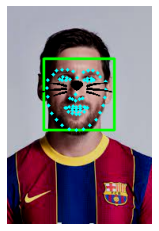

<Sticker result Level 2>


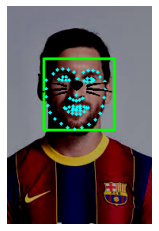

<Sticker result Level 3>


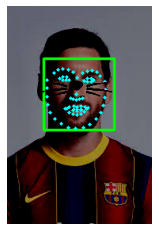

<Sticker result Level 4>


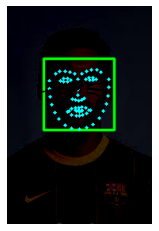

In [18]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식
for i in range(4):
    sticker_area = sub[i][refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    sub[i][refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
    # 원본이미지img_show의 [] 내부에 해당하는 부분은 새로운 값을 재위치키라는 뜻
    print(f"<Sticker result Level {i+1}>")
    plt.axis("off")
    plt.imshow(sub[i])
    plt.show()

cell 19

Final Output


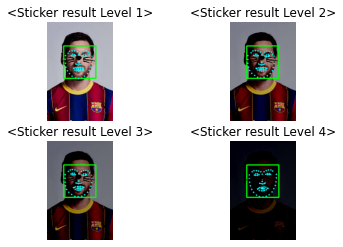

In [19]:
#Output
print("Final Output")
for i in range(4):
    sticker_area = sub_output[i][refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    sub_output[i][refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
    # 원본이미지img_show의 [] 내부에 해당하는 부분은 새로운 값을 재위치키라는 뜻
    
    plt.subplot(2,2,i+1)
    plt.title(f"<Sticker result Level {i+1}>")
    plt.axis("off")
    plt.imshow(sub_output[i])